# Measuring Tiefststände

In [1]:
require(dplyr)
require(ggplot2)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2



In [2]:
# load data
stammdaten = read.csv("messstellen.csv")
nw_monthly = read.csv("monthly/nw_monthly.csv")

In [3]:
# get lowest value for each messstelle
mins = nw_monthly %>%
    group_by(ms_nr) %>%
    summarise(min_gwl = min(min_gwl, na.rm=TRUE))
mins %>%
    head()

ms_nr,min_gwl
<chr>,<dbl>
nw-100030014,50.90
nw-100130124,93.20
nw-100135523,37.08
nw-100140038,47.74
nw-100140117,46.91
nw-100140142,50.00


In [4]:
# get each occurence of lowest value
# sometimes one measuring station reachest the same low point in multiple years
mins = mins %>%
    merge(., nw_monthly, how="left", on="min_gwl", all.x=TRUE, all.y=FALSE) %>%
    select(ms_nr, year)
mins %>%
    head()

,ms_nr,year
,<chr>,<int>
1,nw-100030014,2014
2,nw-100130124,2019
3,nw-100135523,2009
4,nw-100140038,1997
5,nw-100140117,1997
6,nw-100140142,2019


In [5]:
# calculate total messstellen that reached min value per kreis
mins_by_year = stammdaten %>%
    filter(behoerde == "nw", pct_data_1990_2021 >= .95, is.na(trend_normalized)) %>% 
    group_by(ags) %>%
    mutate(total_messstellen = n()) %>% # first calculate messstellen total for kreis
    select(ms_nr, kreis, bez, ags, total_messstellen) %>%
    merge(., mins, on="ms_nr", how="outer") %>% # then merge with mins
    group_by(kreis, bez, ags, year, total_messstellen) %>%
    summarise(n = n()) %>%
    mutate(pct = n/total_messstellen) %>% # calculate percent reaching min in given year
    arrange(kreis, year) %>%
    mutate_if(is.numeric, round, 2)
mins_by_year %>%
    head()

`summarise()` has grouped output by 'kreis', 'bez', 'ags', 'year'. You can
override using the `.groups` argument.
`mutate_if()` ignored the following grouping variables:
• Columns `kreis`, `bez`, `ags`, `year`


kreis,bez,ags,year,total_messstellen,n,pct
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
Düren,Kreis,5358,2011,1,1,1
Recklinghausen,Kreis,5562,2021,1,2,2
Rhein-Erft-Kreis,Kreis,5362,1996,1,1,1
Städteregion Aachen,Kreis,5334,1991,1,1,1
Städteregion Aachen,Kreis,5334,1992,1,1,1


In [6]:
# can also look at the data as wide df
mins_by_year %>%
    select(-c("pct")) %>%
    arrange(year) %>%
    tidyr::pivot_wider(names_from="year", values_from="n", values_fill=0) %>%
    head()

kreis,bez,ags,total_messstellen,1991,1992,1996,2011,2021
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Städteregion Aachen,Kreis,5334,1,1,1,0,0,0
Rhein-Erft-Kreis,Kreis,5362,1,0,0,1,0,0
Düren,Kreis,5358,1,0,0,0,1,0
Recklinghausen,Kreis,5562,1,0,0,0,0,2


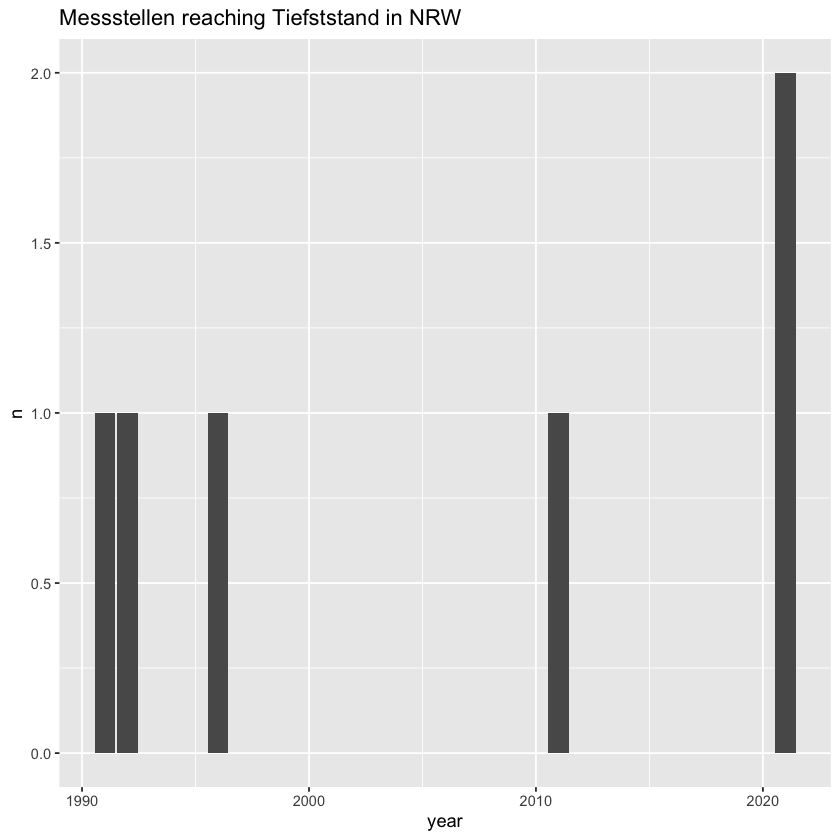

In [7]:
# get mins for entire bundesland and plot over time
mins_by_year %>%
    group_by(year) %>%
    summarise(n = sum(n)) %>%
    ggplot(., aes(year, n)) +
    geom_bar(stat="identity") +
    ggtitle("Messstellen reaching Tiefststand in NRW")

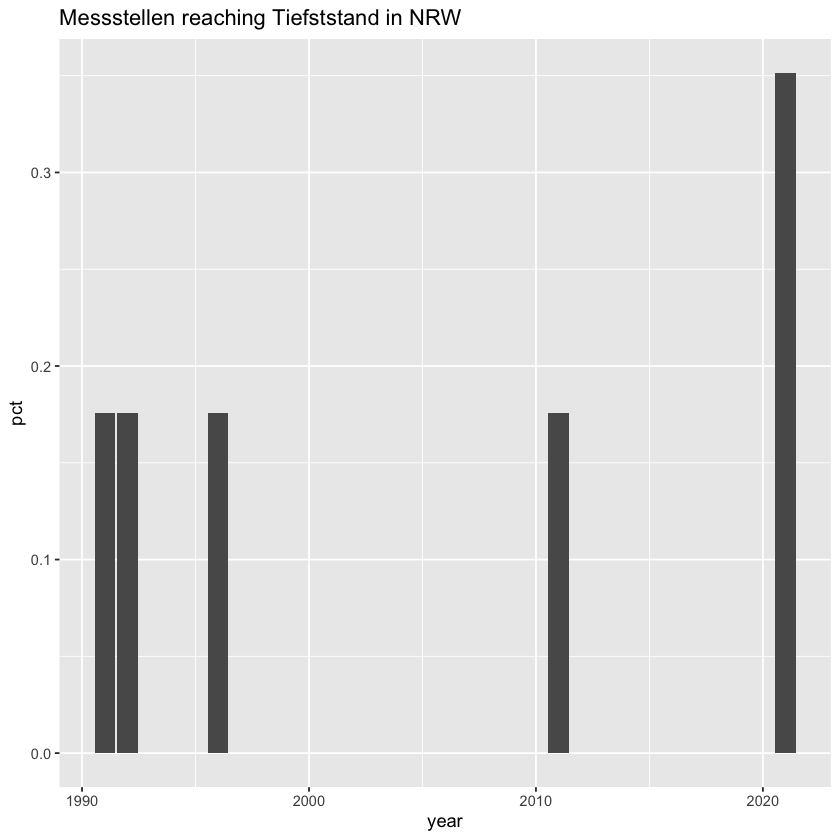

In [8]:
# get mins for entire bundesland and plot over time as %
mins_by_year %>%
    group_by(year) %>%
    summarise(n = sum(n)) %>%
    mutate(total_messstellen = nrow(stammdaten[stammdaten$behoerde == "nw",])) %>%
    mutate(pct = 100*n/total_messstellen) %>%
    ggplot(., aes(year, pct)) +
    geom_bar(stat="identity") +
    ggtitle("Messstellen reaching Tiefststand in NRW")